In [2]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import neurom as nm
from bluepy import Circuit
import seaborn as sns
import blueetl
import re
import matplotlib.pyplot as plt
import json

In [3]:
with open('../data/morphologies/morphometrics/config.json','rb') as f:
    metrics_config = json.load(f)

FEATURES = list(metrics_config['neurite'].keys())

In [27]:
FEATURES_small = ["total_length", "total_height", "total_area", "number_of_sections", "section_lengths"]
NEURITES = {"apical": nm.core.types.NeuriteType.apical_dendrite,
            "basal": nm.core.types.NeuriteType.basal_dendrite,
            "axon": nm.core.types.NeuriteType.axon}


def get_features(morph_paths):
    """Get morphometric features for all morphologies passed"""
    features = {"acronym": [], "feature_name": [], "feature_val": [], "loc": []}
    for mtype, paths in tqdm(morph_paths.items(), desc="mtypes"):
        for path in tqdm(paths, desc="morphologies", miniters=len(paths)/100, leave=False):
            print(path)
            morph = nm.load_morphology(path)
            for neurite_name, neurite_id in NEURITES.items():
                for feature in FEATURES:
                    features["acronym"].append(mtype)
                    feature_name = "avg_section_length" if feature == "section_lengths" else feature
                    features["feature_name"].append(feature_name)
                    feature_val = nm.get(feature, morph, neurite_type=neurite_id)
                    feature_val = np.mean(feature_val) if feature == "section_lengths" else feature_val
                    features["feature_val"].append(feature_val)
                    features["loc"].append(neurite_name)
    df = pd.DataFrame.from_dict(features)
    #df.drop(df.loc[(df["mtype"] == "L4_SSC") & (df["loc"] == "apical")].index, inplace=True)  # clear L4_SSC apicals...
    return df

In [5]:
# morph_folder = '/gpfs/bbp.cscs.ch/project/proj112/entities/morphologies/20211019/10_ReorientedClonedMorphologies-swc/'
morph_folder = '../data/morphologies/swc30'

In [6]:
morphologies = os.listdir(morph_folder)

In [7]:
for i in morphologies:
    if not i.endswith('swc'):
        print(i)

.ipynb_checkpoints


In [8]:
# # This step is to filter out cloned and scaled morphologies. Not useful for this project
# original_morphs = []
# original_not_scaled_morphs = []

# for i in morphologies:
#     if not re.search('clone',i.lower()):
#         original_morphs.append(i)
#         if not re.search('scale',i.lower()):
#             original_not_scaled_morphs.append(i.split('.')[0])

In [9]:
# len(original_morphs) == len(morphologies)

In [10]:
# df = pd.read_csv('/gpfs/bbp.cscs.ch/project/proj112/entities/bionames/20211110_BioM/bioname/extNeuronDB.dat',sep=' ',header=None)
# df.columns = ['name','layer','mtype','etype','full_name']

df = pd.read_csv('../data/metadata/morph_regions.csv')
df.columns = ['morph_name','acronym']
df

,morph_name,acronym
0,AA0719.swc,VM
1,AA0253.swc,dhc
2,AA0333.swc,FRP6a
3,AA0961.swc,CENT3
4,AA0515.swc,PGRNd
...,...,...
1120,AA0710.swc,PRE
1121,AA0565.swc,dhc
1122,AA0921.swc,VAL
1123,AA0938.swc,PSTN


In [11]:
mtypes, occurences = np.unique(df.acronym.values.astype(str),return_counts=True)

In [12]:
sorted_indices = np.argsort(occurences)[::-1]
sorted_mtypes = mtypes[sorted_indices]
sorted_occurrences = occurences[sorted_indices]

# Display mtypes and occurrences together
for mtype, count in zip(sorted_mtypes, sorted_occurrences):
    print(f"{mtype}: {count} occurrence(s)")

MOs5: 149 occurrence(s)
SUB: 70 occurrence(s)
MOs6a: 64 occurrence(s)
PRE: 59 occurrence(s)
MOs2/3: 49 occurrence(s)
VAL: 36 occurrence(s)
DG-mo: 36 occurrence(s)
POST: 24 occurrence(s)
CA1: 21 occurrence(s)
MOp5: 19 occurrence(s)
dhc: 18 occurrence(s)
MOs1: 17 occurrence(s)
ProS: 16 occurrence(s)
ACAd6a: 16 occurrence(s)
ZI: 14 occurrence(s)
LHA: 14 occurrence(s)
VM: 12 occurrence(s)
PO: 12 occurrence(s)
MOp6a: 12 occurrence(s)
or: 12 occurrence(s)
DG-sg: 12 occurrence(s)
MB: 12 occurrence(s)
VPM: 12 occurrence(s)
CL: 11 occurrence(s)
PG: 10 occurrence(s)
HY: 10 occurrence(s)
MMd: 9 occurrence(s)
PCN: 9 occurrence(s)
TRN: 9 occurrence(s)
MOp2/3: 9 occurrence(s)
AV: 9 occurrence(s)
SIM: 8 occurrence(s)
MY: 8 occurrence(s)
MD: 8 occurrence(s)
ACAd5: 8 occurrence(s)
fp: 7 occurrence(s)
LD: 7 occurrence(s)
MOp1: 6 occurrence(s)
ORBl6a: 6 occurrence(s)
CA3: 6 occurrence(s)
SPVI: 6 occurrence(s)
DG-po: 5 occurrence(s)
VPL: 5 occurrence(s)
VISp5: 5 occurrence(s)
VISl6a: 5 occurrence(s)
MMme:

In [13]:
filtered_mtypes = mtypes[occurences > 30]
filtered_mtypes

array(['DG-mo', 'MOs2/3', 'MOs5', 'MOs6a', 'PRE', 'SUB', 'VAL'],
      dtype='<U9')

In [14]:
df_filtered = df[df.acronym.isin(filtered_mtypes)].copy().reset_index(drop=True) # calculate similarity score with these as a baseline

In [15]:
df_filtered

,morph_name,acronym
0,AA0715.swc,PRE
1,AA0468.swc,PRE
2,AA0825.swc,SUB
3,AA0720.swc,PRE
4,AA0572.swc,DG-mo
...,...,...
458,AA0873.swc,MOs2/3
459,AA0553.swc,MOs6a
460,AA0710.swc,PRE
461,AA0921.swc,VAL


In [16]:
mt_samples = {}
for acronym in np.unique(df_filtered.acronym):
    morphs = df[df.acronym==acronym]['morph_name'].values
    morph_paths = [f'{morph_folder}/{i}' for i in morphs]
    #cur_mt_morph = morph_folder + df_filtered[df_filtered.mtype==mt]['name'].sample(n=1,axis=0).values[0] + '.swc'
    mt_samples[acronym] = morph_paths

In [17]:
def get_features(morph_paths):
    """Get morphometric features for all morphologies passed"""
    features = {"acronym": [], "feature_name": [], "feature_val": [], "loc": []}
    for region, paths in tqdm(morph_paths.items(), desc="regions"):
        tolerance = 100 # maximum this many neurons will be considered. Added for clones, otherwise too long to compute
        num_sample = 0

        for path in tqdm(paths, desc="morphologies", miniters=len(paths)/100, leave=False):
            if num_sample > tolerance:
                continue
            morph = nm.load_morphology(path)
            for neurite_name, neurite_id in NEURITES.items():
#                 if mtype != 'SP_PC' and neurite_name=='apical':
#                     continue
                for feature in FEATURES:
                    features["acronym"].append(region)
                    feature_name = "avg_section_length" if feature == "section_lengths" else feature
                    features["feature_name"].append(feature_name)
                    feature_val = nm.get(feature, morph, neurite_type=neurite_id)
                    feature_val = np.mean(feature_val) if feature == "section_lengths" else feature_val
                    features["feature_val"].append(feature_val)
                    features["loc"].append(neurite_name)
            num_sample += 1
            
    df = pd.DataFrame.from_dict(features)
    #df.drop(df.loc[(df["mtype"] == "L4_SSC") & (df["loc"] == "apical")].index, inplace=True)  # clear L4_SSC apicals...
    return df

In [18]:
fd = get_features(mt_samples) # needs to sample 100 neurons max to be fast

morphologies:   0%|          | 0/36 [00:00<?, ?it/s]/gpfs/bbp.cscs.ch/home/kurban/venv2022/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs/bbp.cscs.ch/home/kurban/venv2022/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)

regions: 100%|██████████| 7/7 [05:14<00:00, 44.92s/it]       


In [19]:
output_file_name = '../data/morphologies/morphometrics/21_features_acronym.csv'
fd.to_csv(output_file_name)

In [23]:
fd_small = pd.read_csv( '../data/morphologies/morphometrics/basic_features_acronym.csv',index_col=0)

In [25]:
df_features = fd

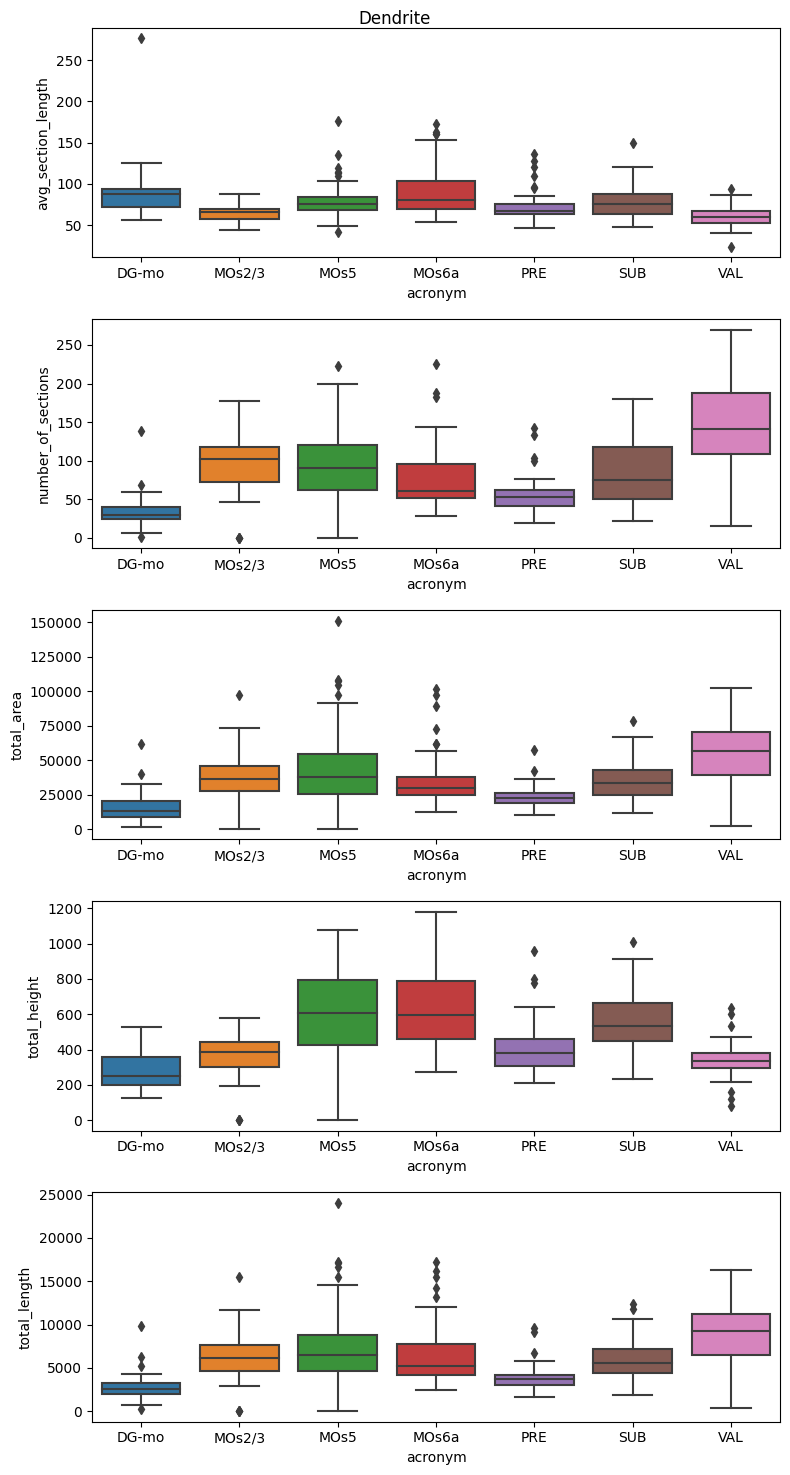

In [34]:
df_features = fd_small
f = plt.subplots(len(FEATURES_small),1,figsize=(8,15))
for idx,feature_name in enumerate(np.unique(df_features['feature_name'])):
    plt.subplot(len(FEATURES_small),1,idx+1)
    dff = df_features.etl.q(feature_name=feature_name,loc='basal')
    sns.boxplot(data=dff, x="acronym", y="feature_val")
    plt.ylabel(feature_name)
    
plt.suptitle('Dendrite')
plt.tight_layout()

# plt.savefig('../Results/morphometrics/basic_features_different_MO_dendrites.png')
# plt.savefig('../Results/morphometrics/basic_features_different_MO_dendrites.svg')

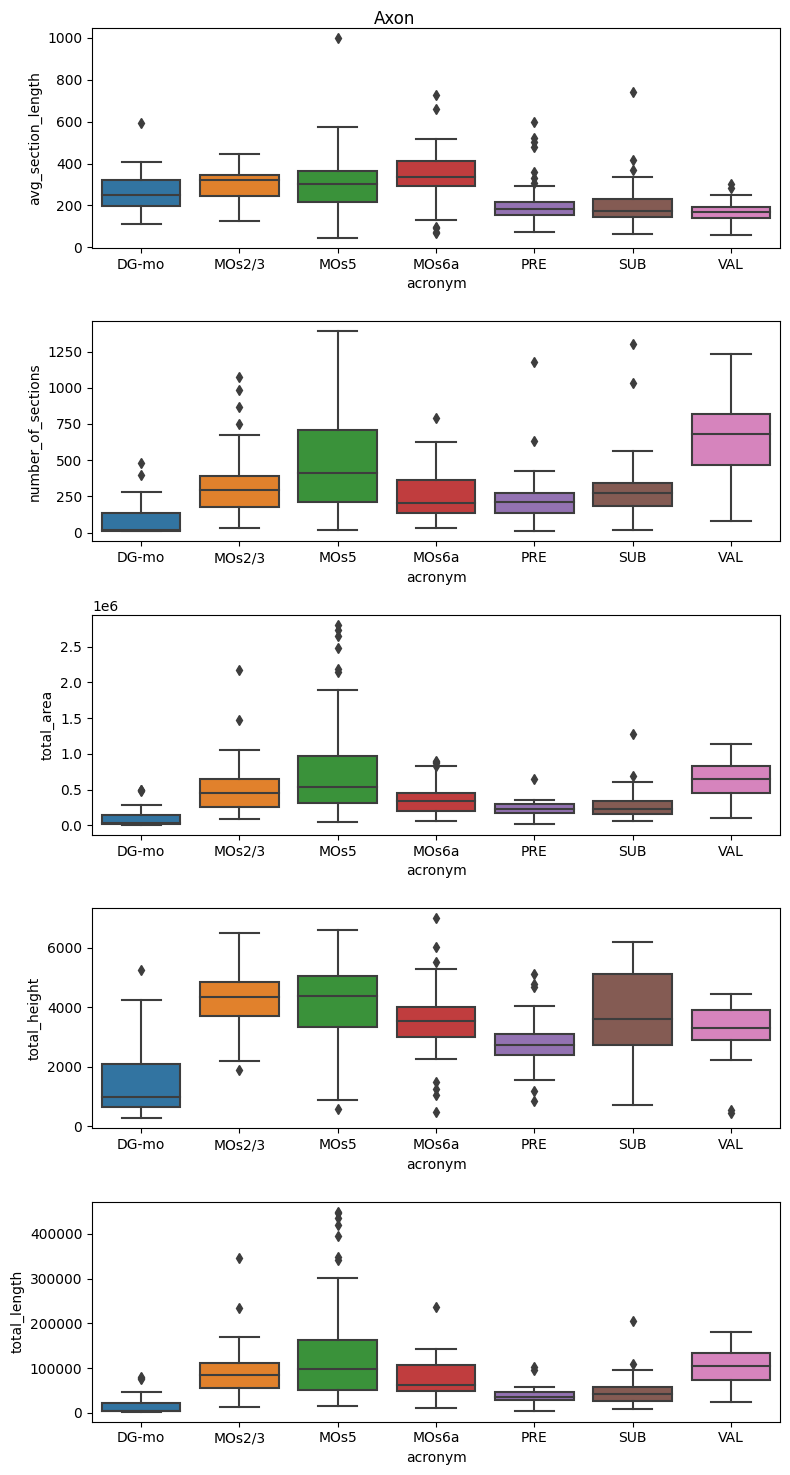

In [36]:
df_features = fd_small
f = plt.subplots(len(FEATURES_small),1,figsize=(8,15))
for idx,feature_name in enumerate(np.unique(df_features['feature_name'])):
    plt.subplot(len(FEATURES_small),1,idx+1)
    dff = df_features.etl.q(feature_name=feature_name,loc='axon')
    sns.boxplot(data=dff, x="acronym", y="feature_val")
    plt.ylabel(feature_name)
    
plt.suptitle('Axon')
plt.tight_layout()

# plt.savefig('../Results/morphometrics/basic_features_different_MO_dendrites.png')
# plt.savefig('../Results/morphometrics/basic_features_different_MO_dendrites.svg')

In [37]:
dff

,acronym,feature_name,feature_val,loc
10,DG-mo,total_length,3026.188065,axon
25,DG-mo,total_length,3632.706272,axon
40,DG-mo,total_length,3175.294895,axon
55,DG-mo,total_length,3638.471993,axon
70,DG-mo,total_length,3931.579402,axon
...,...,...,...,...
6160,VAL,total_length,27789.831791,axon
6175,VAL,total_length,108636.129128,axon
6190,VAL,total_length,116955.376880,axon
6205,VAL,total_length,141903.958972,axon


In [62]:
pd.set_option('mode.chained_assignment', None)

In [64]:
len(FEATURES)

21

/nvme/kurban/1551923/ipykernel_67734/371812773.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dff.loc[:,'feature_val'] = dff.loc[:,'feature_val'].apply(np.mean)
/nvme/kurban/1551923/ipykernel_67734/371812773.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dff.loc[:,'feature_val'] = dff.loc[:,'feature_val'].apply(np.mean)
/nvme/kurban/1551923/ipykernel_67734/371812773.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the ol

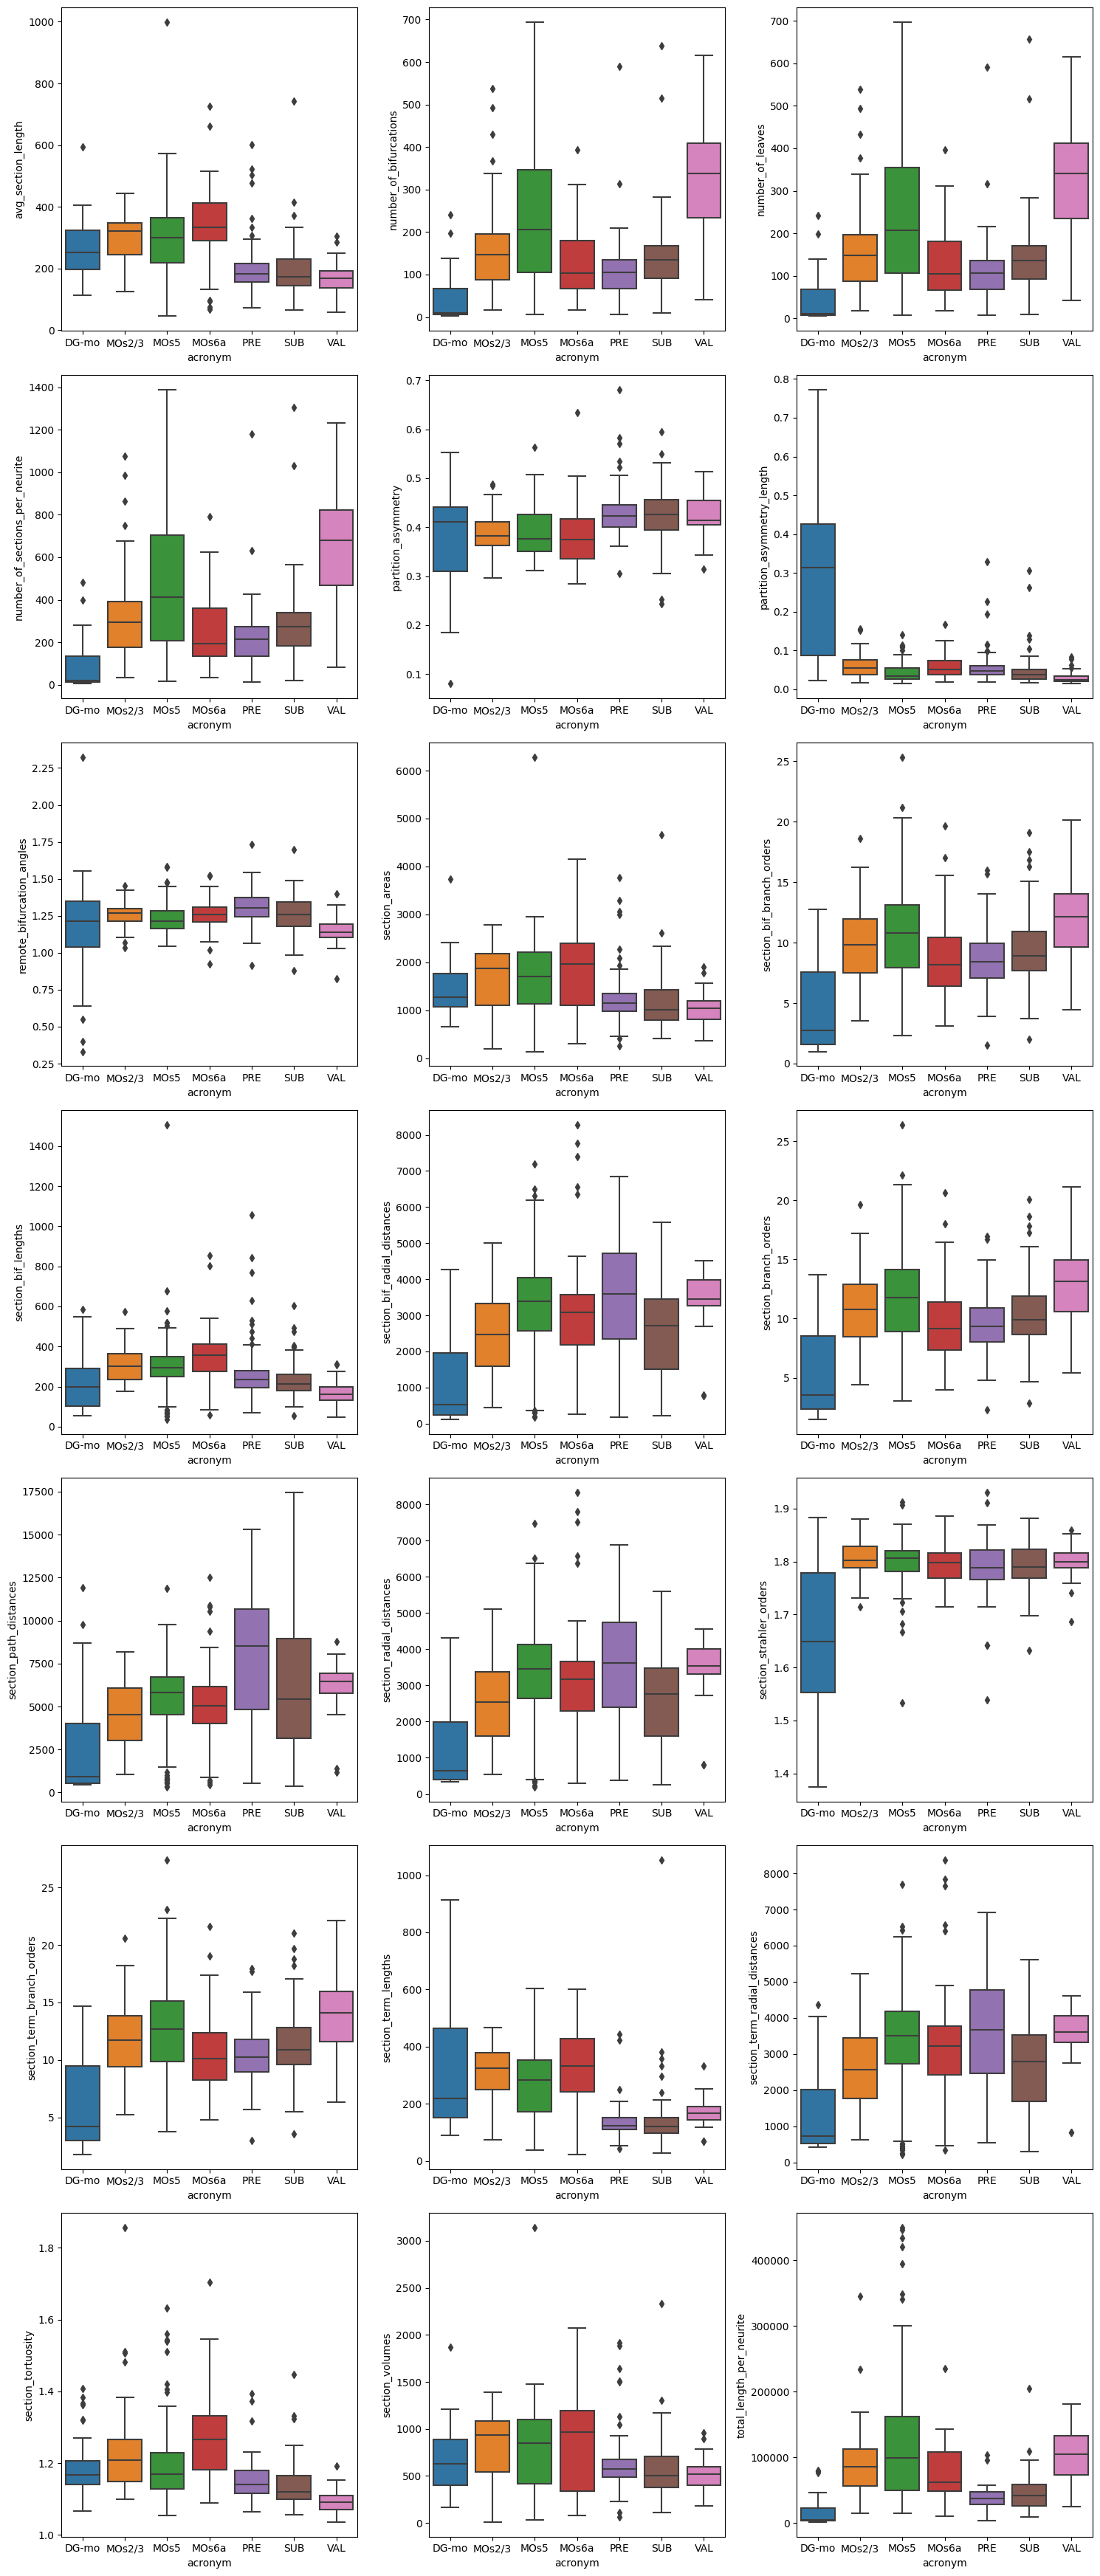

In [77]:
df_features = fd
f = plt.subplots(7,3,figsize=(15,35))
for idx,feature_name in enumerate(np.unique(df_features['feature_name'])):
    plt.subplot(7,3,idx+1)
    dff = df_features.etl.q(feature_name=feature_name,loc='axon')
    try:
        sns.boxplot(data=dff, x="acronym", y="feature_val")
    except Exception as e:
        dff.loc[:,'feature_val'] = dff.loc[:,'feature_val'].apply(np.mean)
#         print(dff['feature_val'].iloc[0])
        sns.boxplot(data=dff, x="acronym", y="feature_val")

    plt.ylabel(feature_name)

# plt.suptitle('Axon')
plt.tight_layout()

plt.savefig('../Results/morphometrics/21_features_different_MO_dendrites.png')
plt.savefig('../Results/morphometrics/21_features_different_MO_dendrites.svg')